# Linear Regression with One Neuron

Version 1.03

(C) 2020 - Umberto Michelucci, Michela Sperti

This notebook is part of the book _Applied Deep Learning: a case based approach, **2nd edition**_ from APRESS by [U. Michelucci](mailto:umberto.michelucci@toelt.ai) and [M. Sperti](mailto:michela.sperti@toelt.ai).

The purpose of this notebook is to give an example of an application of Linear Regression performed with One Neuron to a dataset taken from real world.

## Notebook Learning Goals

At the end of the notebook you are going to have a clear idea of what linear regression is, seen through a practical example. Moreover, you will have learnt what is one of the simplest tasks that Neural Networks can solve. You can of course perform linear regression easily by applying traditional math formulas or using dedicated functions such as those found in scikit-learn. However, it is very instructive to follow this example, since it gives a practical grasp of how the building blocks of Deep Learning architectures (i.e. neurons) work.

## Real Case Example: **Radon Contamination**



### Dataset Overview

Radon is a radioactive gas that enters homes through contact points with the ground. It is a carcinogen that is the primary cause of lung cancer in non-smokers. Radon levels vary greatly from household to household. This dataset contains measured radon levels in U.S. homes by county and state. The *activity* label is the measured radon concentration in *pCi/L*. Important predictors are: 
- *floor* (the floor of the house in which the measurement was taken), 
- *county* (the U.S. county in which the house is located), and 
- *uppm* (a measurement of uranium level of the soil by county).


This dataset fits well a classical regression problem, since it contains a continuous variable (radon activity) which is interesting to be predicted. The model which will be built is made of one neuron and will fit a linear function to floor, county, uppm and pcterr variables.

### Libraries and Dataset Import

This section contains the necessary libraries (such as tensorflow or pandas) you need to import to run the notebook.

In [1]:
# This command install code from the tensorflow docs repository.
# We need to use tensorflow_docs.modeling function when training our model.
# This function will generate a report on the network's perfomances
# step by step during the training phase (see Training Phase section of the
# notebook). 

# You can safely ignore this cell if you don't understand what it does.

!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0ue3xzpj
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-0ue3xzpj
  Resolved https://github.com/tensorflow/docs to commit 8f431e2b96ebbebd325a7162a00c40653af799e5
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180390 sha256=d61e5b9fbc7b499da1922c6f4e42d4deb08a5c20e80b75366f22fd6d2e022f9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-0kvyzbp4/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [2]:
# general libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

# ignore warnings
import warnings
warnings.simplefilter('ignore')

2023-01-19 22:29:33.362291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 22:29:33.469035: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


The following cells are needed to **download** the dataset. You don't need to understand all the download and processing steps, since the focus of this section is to apply a simple linear regression model to a real case dataset (therefore you can just execute the following cells, ignoring their content). If you are interested in the details, you can find the complete code in the /modules folder.

Now we clone the repository for the book to be able to access the modules that we have written for all the juypter notebooks.

In [ ]:
# Referring to the following cell, if you want to re-clone a repository
# inside the google colab instance, you need to delete it first. 
# You can delete the repositories contained in this instance executing 
# the following two lines of code (deleting the # comment symbol).

# !rm -rf ADL-Book-2nd-Ed 
# !rm -rf BCCD_Dataset

In [ ]:
# This command actually clone the repository of the book in the google colab
# instance. In this way this notebook will have access to the modules
# we have written for this book.

# Please note that in case you have already run this cell, and you run it again
# you may get the error message:
#
# fatal: destination path 'ADL-Book-2nd-Ed' already exists and is not an empty directory.
# 
# In this case you can safely ignore the error message.

!git clone https://github.com/toelt-llc/ADL-Book-2nd-Ed.git

fatal: destination path 'ADL-Book-2nd-Ed' already exists and is not an empty directory.


In [3]:
# This cell imports some custom written functions that we have created to 
# make the loading of the data and the plotting easier. You don't need 
# to undertsand the details and you can simply ignore this cell.
# Simply run it with CMD+Enter (on Mac) or CTRL+Enter (Windows or Ubuntu) to
# import the necessary functions.

import sys
sys.path.append('../../modules/')

from read_radon_dataset import read_data
from style_setting import set_style

In [4]:
# This cell provides the dataset on which you will implement the linear regression model.
# Data are temporarily put into "tmp" folder. "url_base" contains the link to access the dataset.

# After cell's execution, you will have a variable containing features ("radon_features"),
# a variable containing labels ("radon_labels") and an informative variable containing
# all countries including in the dataset. 

# You don't need to understand the implementation's details and you can simply ignore this cell.
# Simply run it with CMD+Enter (on Mac) or CTRL+Enter (Windows or Ubuntu) to
# import the necessary functions.

# inputs to download the dataset
CACHE_DIR = os.path.join(os.sep, 'tmp', 'radon')
url_base = 'http://www.stat.columbia.edu/~gelman/arm/examples/radon/'
# Alternative source:
# url_base = ('https://raw.githubusercontent.com/pymc-devs/uq_chapter/master/reference/data/')

rd = read_data(CACHE_DIR, url_base)
radon_features, radon_labels, county_name = rd.create_dataset()

Now you have all the necessary elements to successfully implement this tutorial. **Let's have a look at our data**:

In [5]:
num_counties = len(county_name)
num_observations = len(radon_features)
print('Number of counties included in the dataset: ', num_counties)
print('Number of total samples: ', num_observations)

Number of counties included in the dataset:  85
Number of total samples:  919


In [6]:
radon_features.head()

,floor,county,log_uranium_ppm,pcterr
0,1,0,0.502054,9.7
1,0,0,0.502054,14.5
2,0,0,0.502054,9.6
3,0,0,0.502054,24.3
4,0,1,0.428565,13.8


The dataset is made of **919 observations**, **1 target** column (`activity`) and **4 features** (`floor`, `county`, `log_uranium_ppm`, `pcterr`). 85 different American counties are included in the dataset.

### Dataset Splitting

*In any machine learning project, it is a good behaviour to split the dataset you have at your disposal in different subsets.* Plenty of theoretical explanations about this need is present in literature. In the [Further Readings](#fr) section of the notebook you will find some advice on useful material about this topic. To simply explain the concept: when you build a machine learning model, you first need to train (i.e. build) the model and then you have to test it (i.e. verify the model's performances on never seen before data). The roughest way to do this is to split the dataset into two subsets: 80% of the original dataset to train the model (the more data you have the better your model will perform) and the remaining 20% to test it.

Now we build a train and a test set splitting the dataset randomly in two parts with the following proportions: **80%/20%**. 

In [7]:
np.random.seed(42)
rnd = np.random.rand(len(radon_features)) < 0.8

train_x = radon_features[rnd] # training dataset (features)
train_y = radon_labels[rnd] # training dataset (labels)
test_x = radon_features[~rnd] # testing dataset (features)
test_y = radon_labels[~rnd] # testing dataset (labels)

print('The training dataset dimensions are: ', train_x.shape)
print('The testing dataset dimensions are: ', test_x.shape)

The training dataset dimensions are:  (733, 4)
The testing dataset dimensions are:  (186, 4)


### Linear Regression: the Model

From now on, the interesting part begins. Keep in mind that a one neuron model is an overkill for a regression task. We could solve linear regression exactly without the need of using gradient descent or similar optimisation algorithm (employed in the neuron's architecture). You can find an exact regression solution example, implemented with numpy library, in *Linear_regression_with_numpy.ipynb* notebook. 

To note is (for those with some more experience with neural networks) that we will use **one single neuron** with an **identity function** as activation function. 

Our dataset can be expressed as a matrix ($X$), where the rows represent the different measurements describing radon activity and the columns the 4 features at our disposal. Then, we have the column containing the label we wants to predict ($y$). When we employ one neuron to perform linear regression, we are simply computing the following equation: 

\begin{equation}
\hat{y}=WX+b
\end{equation}

that is a linear combination of the input data and the network's weights plus a constat term (bias) $b$. $\hat{y}$ is the predicted output given a certain input vector ${\bf x} = ({\bf x_1}, {\bf x_2}, ... , {\bf x_{n_x}})$, where we have indicated the number of observations we have at our disposal with $n_x$.

### Structure of the Net

Despite it is very important to keep in mind the previous considerations, developing this model with Keras is straightforward. The following function builds the one neuron model for linear regression.

In [8]:
def build_model():

  # one unit as network's output
  # identity function as activation function
  # sequential groups a linear stack of layers into a tf.keras.Model
  # activation parameter: if you don't specify anything, no activation 
  # is applied (i.e. "linear" activation: a(x) = x).
  model = keras.Sequential([ 
    layers.Dense(1, input_shape = [len(train_x.columns)])
  ])

  # optimizer that implements the RMSprop algorithm
  optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001)

  # the compile() method takes a metrics argument, which is a list of metrics
  # loss = Mean Square Error (mse), metrics = Mean Absolute Error (mae),
  # Mean Square Error (mse)
  model.compile(loss = 'mse',
                optimizer = optimizer,
                metrics = ['mse'])
  
  return model

In [9]:
model = build_model()

2023-01-19 22:30:50.990943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 22:30:52.478739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18271 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:17:00.0, compute capability: 8.6
2023-01-19 22:30:52.479347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 17856 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:73:00.0, compute capability: 8.6
2023-01-19 22:30:52.479787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/t

Let's have a look at the model summary:

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


**Learning rate** is a very important parameter of the optimizer. In fact, it strongly influences the convergence of the minimization process. It is a common and good behaviour to try different learning rate values and see how the model's convergence changes. You can find further reading advices about this topic in the [Further Reading](#fr) section of this notebook.

### Training Phase (Model's Learning Phase)

Training our neuron means finding the weights and biases that minimize a chosen function (usually called the **cost function** and typically indicated by $J$). The cost function to be minimized in the case of a linear regression task is the **mean square error**. The most famous numerical method to find the minimum of a given function is the **gradient descent** (it is suited for cases in which the solution can not be found analytically, such as all neural network applications). In our example we used the **RMSprop algorithm** as optimizer. 

The minimization process is iterative, therefore it is necessary to decide when to stop it. The simplest way is to set a number of repetitions (called **epochs**) and to run the algorithm that fixed number of times. Then, results are checked to see if an optimal point has been reached. If not, the number of epochs is increased.  

We start training our model for **1000** epochs and we look at the summary in terms of performances (MSE). 

In [11]:
EPOCHS = 1000

history = model.fit(
  train_x, train_y,
  epochs = EPOCHS, verbose = 0,
  callbacks = [tfdocs.modeling.EpochDots()])

2023-01-19 22:31:29.571194: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7efb68a46b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-19 22:31:29.571220: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
2023-01-19 22:31:29.571225: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA RTX A4500, Compute Capability 8.6
2023-01-19 22:31:29.571228: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): NVIDIA RTX A4500, Compute Capability 8.6
2023-01-19 22:31:29.574745: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-19 22:31:29.705795: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 0, loss:1239.9492,  mse:1239.9492,  
....................................................................................................
Epoch: 100, loss:19.9223,  mse:19.9223,  
....................................................................................................
Epoch: 200, loss:16.6644,  mse:16.6644,  
....................................................................................................
Epoch: 300, loss:16.1457,  mse:16.1457,  
....................................................................................................
Epoch: 400, loss:16.0605,  mse:16.0605,  
....................................................................................................
Epoch: 500, loss:16.0184,  mse:16.0184,  
....................................................................................................
Epoch: 600, loss:16.0210,  mse:16.0210,  
.................................................................................................

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,epoch
995,15.979374,15.979374,995
996,15.955188,15.955188,996
997,15.984493,15.984493,997
998,15.972133,15.972133,998
999,15.960743,15.960743,999


You can noticed that while the number of epochs increases, the MSE is minimized. But *which is the best number of epochs to set*? A possible hint can be given by the plot of the **cost function vs. number of iterations**. Let's plot it. If you are interested in plotting details you can find the complete code inside the /module folder.

The cost function vs. number of iterations plot is also useful to evaluate the model's convergence for different learning rates.

In [ ]:
# The following line contains the path to fonts that are used to plot result in
# a uniform way.

#f = set_style().set_general_style_parameters()

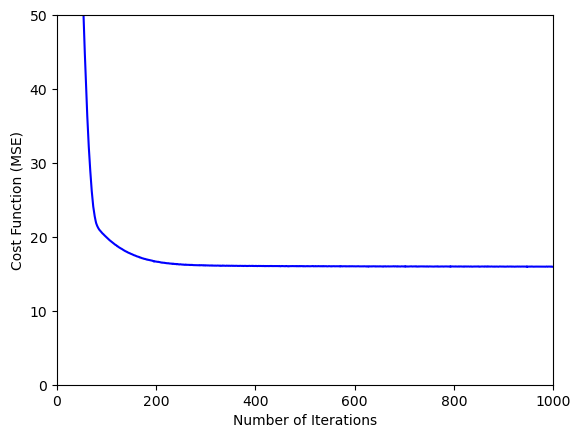

In [13]:
# Cost Function vs. Number of Iterations PLOT
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(hist['epoch'], hist['mse'], color = 'blue')

#plt.ylabel('Cost Function (MSE)', fontproperties = fm.FontProperties(fname = f))
#plt.xlabel('Number of Iterations', fontproperties = fm.FontProperties(fname = f))

plt.ylabel('Cost Function (MSE)')
plt.xlabel('Number of Iterations')


plt.ylim(0, 50)
plt.xlim(0, 1000)

plt.axis(True)
plt.show()

Looking at the previous plot, you can notice that, after 400 epochs, the cost function remains almost constant in its value, indicating that a minimum has been reached.

Let's have a look at the **estimated weights** of our neuron model. The first four can be seen as the linear regression coefficients, while the last one is the bias term. Keep in mind that the neuron performs the following operation:

\begin{equation}
\hat{y}=WX+b
\end{equation}

You can compare these numbers with the ones obtained in the *Linear_regression_with_numpy.ipynb* notebook.

In [14]:
weights = model.get_weights() # return a numpy list of weights
print(weights)

[array([[-6.9541436e-01],
       [ 1.2530622e-03],
       [ 3.0266027e+00],
       [-2.0345743e-01]], dtype=float32), array([4.043494], dtype=float32)]


### Testing Phase (Model's Performances Evaluation)

Now, to know if the model you have just built is suited to be applied to unseen data, you have to check its performances over the test set. In the following cell the linear model is applied to the test set to make predictions (`test_predictions`). Then, predicted radon activity values are compared with real values (`test_y`) by simply plotting **predictions vs. true values**. An optimal model shows points distributed over the black solid line present in the plot. 

6/6 [==============================] - 0s 2ms/step


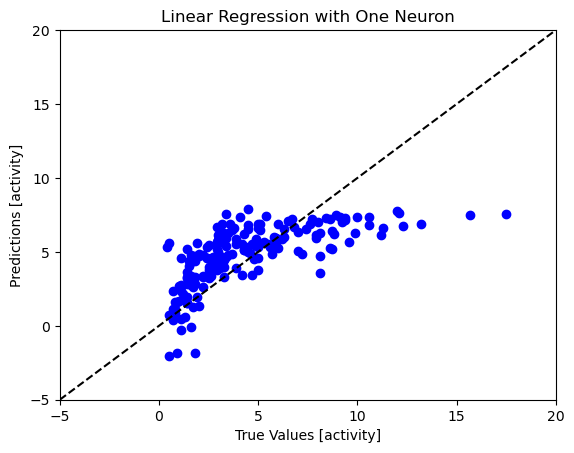

In [15]:
%matplotlib inline


test_predictions = model.predict(test_x).flatten() # predict radon activities with the built linear regression model

# Predictions vs. True Values PLOT

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(test_y, test_predictions, marker = 'o', c = 'blue')
plt.plot([-5,20], [-5,20], color = 'black', ls = '--')

#plt.ylabel('Predictions [activity]', fontproperties = fm.FontProperties(fname = f))
#plt.xlabel('True Values [activity]', fontproperties = fm.FontProperties(fname = f))
#plt.title('Linear Regression with One Neuron', fontproperties = fm.FontProperties(fname = f))

plt.ylabel('Predictions [activity]')
plt.xlabel('True Values [activity]')
plt.title('Linear Regression with One Neuron')


plt.ylim(-5, 20)
plt.xlim(-5, 20)

plt.axis(True)
plt.show()

This plots shows that linear regression is too simple to accurately model this dataset's behaviour and a more complex model is needed.

## Exercises

1. [*Easy Difficulty*] Try using only one feature to predict radon activity and see how results change.
2. [*Medium Difficulty*] Try to change the `learning_rate` parameter and see how the model's convergence changes. Then try to reduce the `EPOCHS` parameter and see when the model cannot reach convergence.
3. [*Medium Difficulty*] Try to see how model's results change based on the training dataset's size (reduce it and use different sizes comparing the final results).

## References

1. https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer (radon dataset loading and preprocessing) 
2. https://www.tensorflow.org/datasets/catalog/radon (dataset explanation)

## Further Readings <a name = "fr"></a>

**Dataset Splitting, Overfitting & Underfitting**

1. Lever, Jake, Martin Krzywinski, and Naomi Altman. "Points of significance: model selection and overfitting." (2016): 703.
2. Srivastava, Nitish, et al. "Dropout: a simple way to prevent neural networks from overfitting." The journal of machine learning research 15.1 (2014): 1929-1958.

**Learning Rate**

1. Bengio, Yoshua. "Practical recommendations for gradient-based training of deep architectures." Neural networks: Tricks of the trade. Springer, Berlin, Heidelberg, 2012. 437-478.